### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 8
### Due: Saturday, Apr 17th at 11.59pm CST
---

## Only one problem this week

This problem is mostly about generative classification, but will include one discriminative classifer that we'll meet in `Lecture_20`.

1. Use the following code snippet to read in SDSS galaxy color data.
```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```
This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

#### Part 1

In [1]:
# BS - import the basic things

import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics 
%matplotlib inline
%config InlineBackend.figure_format='retina'

# BS - fetch the data
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()

In [2]:
# BS - print the column names
print("The column names are: ", data.dtype.names)

# BS - create the color arrays
u_g = data['u'] - data['g']
g_r = data['g'] - data['r']
r_i = data['r'] - data['i']
i_z = data['i'] - data['z']

# BS - create the spectral class array
spec_class = data['specClass']

# BS - create redshift array (Note to self: be careful about confusing color 'z' and redshift 'z')
redshift = data['redshift']

The column names are:  ('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')


In [3]:
# BS - create mask to quantify galaxy and quasar labels
mask_gal = (spec_class == 'GALAXY')
mask_quas = (spec_class == 'QSO')

# BS - create array for quasars and galaxies (quasars = 1, galaxies = 0)
gal_quas_binary = np.zeros(len(spec_class))
gal_quas_binary[mask_quas] = 1

# BS - print number of quasars and galaxies
print("Number of galaxies: {} \nNumber of quasars: {}".format(np.sum(mask_gal), np.sum(mask_quas)))

Number of galaxies: 42804 
Number of quasars: 7196


#### Part 2

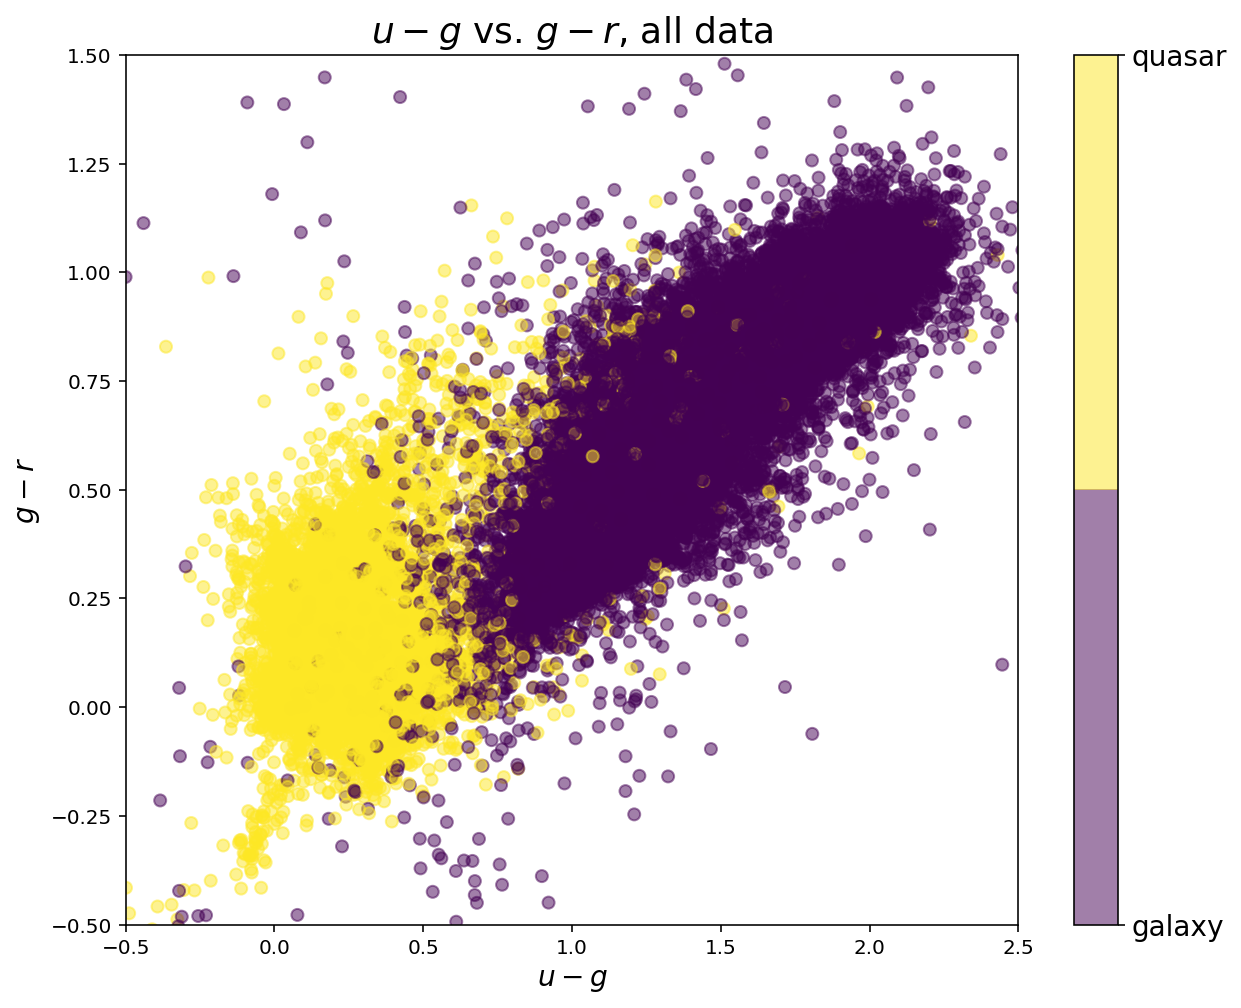

In [4]:
# BS - plot the original data (I feel like I had to pull some chickanery here 
# to get the colorbar to work decently)

fig = plt.figure(figsize=(10,8))
ax = plt.subplot()
im = ax.scatter(u_g, g_r, c=gal_quas_binary, cmap=plt.cm.get_cmap('viridis', 2), alpha=0.5)
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 1.5)
ax.set_xlabel(r"$u-g$", fontsize=14)
ax.set_ylabel(r"$g-r$", fontsize=14)
ax.set_title(r"$u-g$ vs. $g-r$, all data", fontsize=18)
cbar = fig.colorbar(im, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['galaxy', 'quasar'], fontsize=14)
plt.show()


#### Part 3

In [5]:
# BS - stack the colors and redshifts
X = np.stack((u_g, g_r, r_i, i_z, redshift), axis=1)

# BS - reassign just for convention
y = gal_quas_binary

# BS - import the train-test-split package
from sklearn.model_selection import train_test_split

# BS - split into test and training sets for X, and y, test set is 0.2 and training set is 0.8 of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# BS - This seems like the best place to do this. For each of the models that come later
# I am going to use these two arrays to store the best fpr values and best tprs for the best 
# iteration of each model so that I can compare each "best iteration" across models in part 9.
best_fprs = []
best_tprs = []

#### Part 4

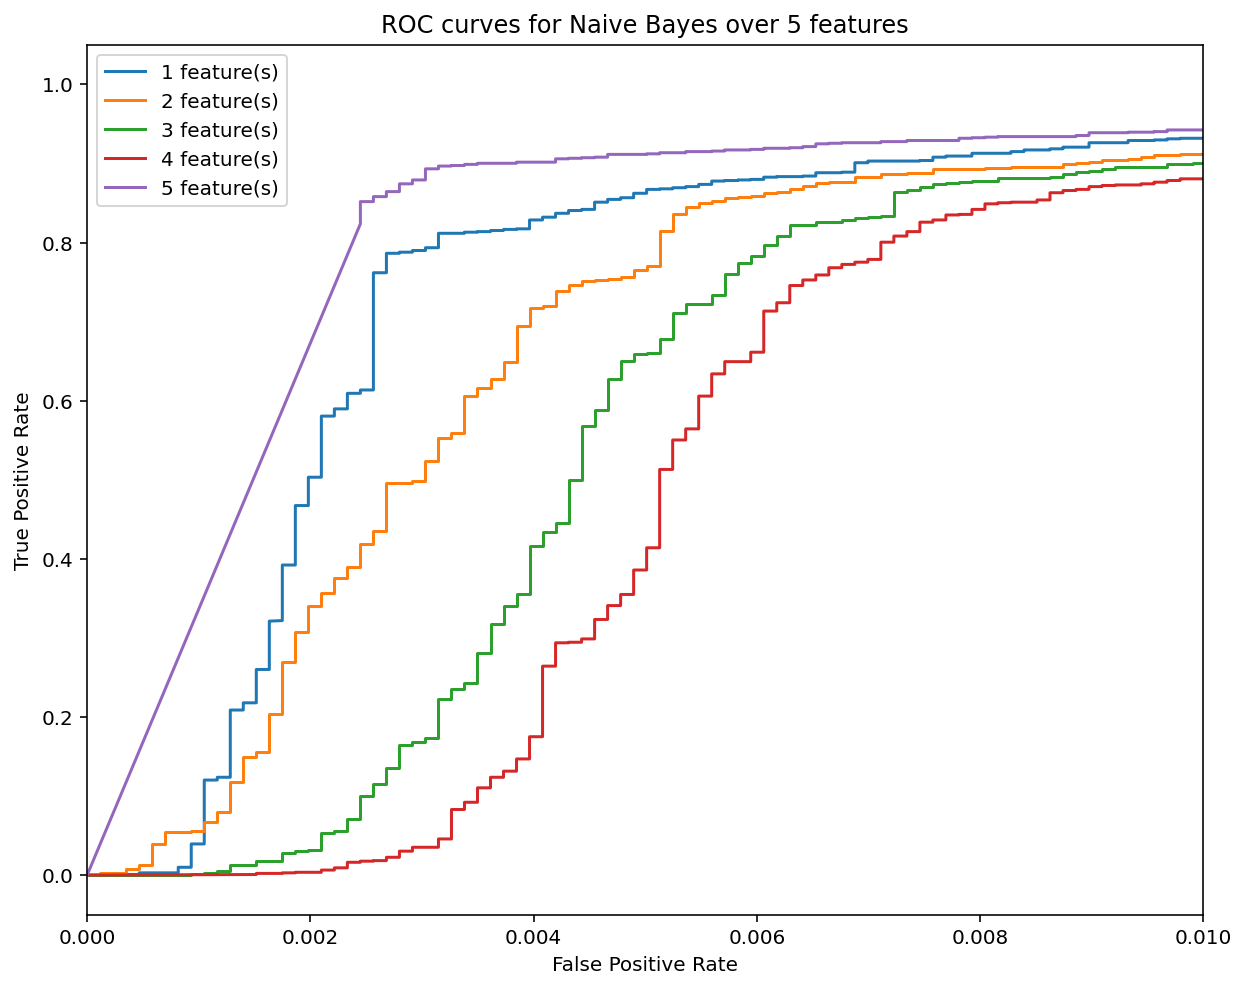

Best model uses 5 features


In [6]:
# BS - import Naive Bayes and ROC curve packages
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve

# BS - create the model
gnb = GaussianNB()

# BS - create the figure object for the plot before the loop since
# I am going to be doing 'plot stuff' in the loop
plt.figure(figsize=(10, 8))

# BS - arrays to store the fprs and tprs for each successive feature
fprs_gnb = []
tprs_gnb = []

# BS - To choose the 'best model', I am going to calculate the area under the
# curve within the following loop and store each of those areas in this array. 
areas_gnb = []

# BS - loop over the number of features, fit X with columns up to
# that number of features, predict targets and probabilities, and 
# create the ROC curve for that number of features, calculate the area
# under the curve, and plot the iteration
for i in range(len(X[0])):

    # BS - fit the classifier object to the training data for the number
    # of features up to that iteration of the loop
    clf = gnb.fit(X_train[:,0:i+1], y_train)
    
    # BS - predict the target with the testing data (I don't think I actually
    # need this, it is just habit at this point)
    y_pred = clf.predict(X_test[:,0:i+1])
    
    # BS calculate the probabilities for the targets from the testing data
    # (as noted, predict_proba returns an array with as many columns as classes,
    # galaxies are classified by 0 and quasars by 1, and so I want the column indexed by
    # 1 to get the probabilites for the quasars)
    y_probs = clf.predict_proba(X_test[:,0:i+1])[:, 1]

    # BS - store the false positive and true positive rates on the dependent variable
    # for the testing data
    fpr, tpr, thresh = roc_curve(y_test, y_probs)
    
    # BS - append false positive and true positive rates for each iteratoin
    fprs_gnb.append(fpr)
    tprs_gnb.append(tpr)
    
    # BS - Take the area under the curve using numpy's trapz (trapezoidal rule)
    # note - I use a mask to take the area under the curve for just the range
    # that is plotted. In theory, I don't think it makes a difference whether I do this
    # or over the whole range, but conceptually it just makes more sense to me to do it
    # this way
    mask = (fpr <= 0.01)
    area = np.trapz(tpr[mask], fpr[mask], axis=0)
    
    # BS - append the area for this iteration
    areas_gnb.append(area)

    # BS - plot false positive vs. true positive for the iteration/number of features
    plt.plot(fpr, tpr, label="%i feature(s)" %(i+1))

# BS - find the max area from the list of areas calculated from each feature
best_gnb = np.argmax(np.array(areas_gnb))

# BS - finish the plot (xlim 0 - 0.01)
plt.xlim(0,0.01)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for Naive Bayes over %i features" %len(X[0]))
plt.legend()
plt.show()

# BS - print best model (note: +1 added to go from computer indexing to feature number indexing)
print("Best model uses {} features".format(best_gnb+1))
    
# BS - ***ANALYSIS*** - it looks to me like adding successive features of color actually makes
# the classification worse...until we get to the redshift feature. Afer this feature is added,
# the classification gets exceptionally better.

# BS - Since later it asks to find the best number of features omitting redshift, and redshift
# changes roc curve so much, I am going to manually add the second best set of fpr and tpr values
# here. This way, I don't have to redo this whole thing again while just omitting the last feature.
best_fprs.append(fprs_gnb[0])
best_tprs.append(tprs_gnb[0])


SRT: Excellent analysis and exquisite code commenting, Bill.

#### Part 5

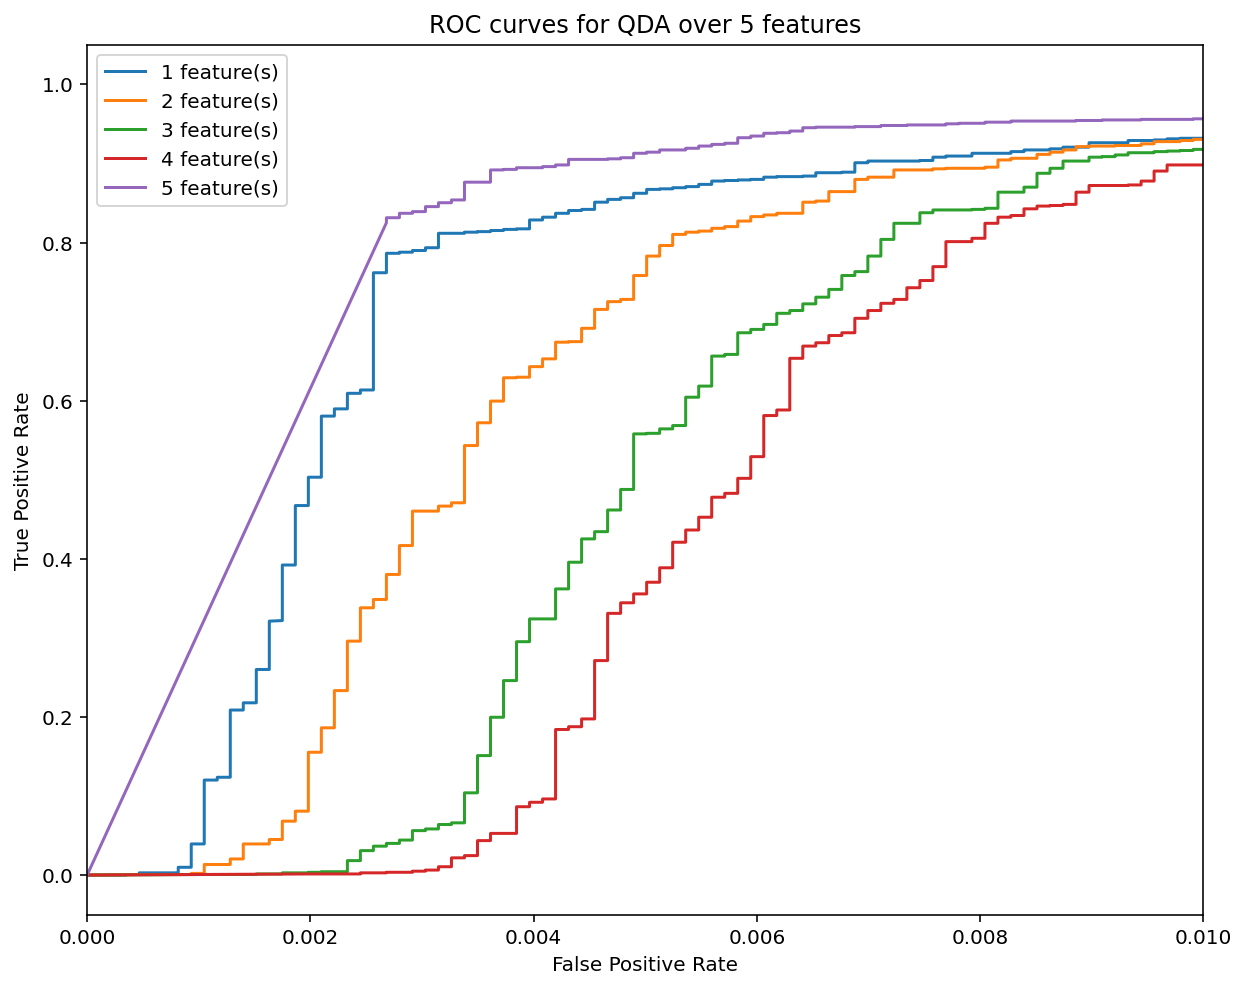

Best model uses 5 features


In [7]:
# BS - import the QDA package
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# BS - create the model
qda = QuadraticDiscriminantAnalysis()

# BS - create the figure object
plt.figure(figsize=(10, 8))

# BS arrays for fprs, tprs, and areas under curve for qda
fprs_qda = []
tprs_qda = []
areas_qda = []

# BS - loop over the number of features, fit X with columns up to
# that number of features, predict targets and probabilities, and 
# create the ROC curve for that number of features, calculate the area
# under the curve, and plot the iteration
for i in range(len(X[0])):
    
    # BS - fit the classifier object to the training data for the number
    # of features up to that iteration of the loop
    clf = qda.fit(X_train[:,0:i+1], y_train)
    
    # BS - predict the target with the testing data (I don't think I actually
    # need this, it is just habit at this point)
    y_pred = clf.predict(X_test[:,0:i+1])
    
    # BS calculate the probabilities for the targets from the testing data
    # (as noted, predict_proba returns an array with as many columns as classes,
    # galaxies are classified by 0 and quasars by 1, and so I want the column indexed by
    # 1 to get the probabilites for the quasars)
    y_probs = clf.predict_proba(X_test[:,0:i+1])[:, 1]
    
    # BS - store the false positive and true positive rates on the dependent variable
    # for the testing data
    fpr, tpr, thresh = roc_curve(y_test, y_probs)
    fprs_qda.append(fpr)
    tprs_qda.append(tpr)
    
    # BS - area under curve for best feature # selection
    mask = (fpr <= 0.01)
    area = np.trapz(tpr[mask], fpr[mask], axis=0)
    areas_qda.append(area)

    # BS - plot false positive vs. true positive for the iteration/number of features
    plt.plot(fpr, tpr, label="%i feature(s)" %(i+1))


# BS - finish the plot (xlim 0 - 0.01)
plt.xlim(0,0.01)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for QDA over %i features" %len(X[0]))
plt.legend()
plt.show()

# BS - print best # of features
best_qda = np.argmax(np.array(areas_qda))
print("Best model uses {} features".format(best_qda + 1))

# BS - ***ANALYSIS*** - The QDA looks uncomfortably similar to the GNB above.
# The qualitative analysis is essentially identical

# BS - same as for GNB above, manually select the best non-redshift ROC curve
best_fprs.append(fprs_qda[0])
best_tprs.append(tprs_qda[0])

#### Part 6

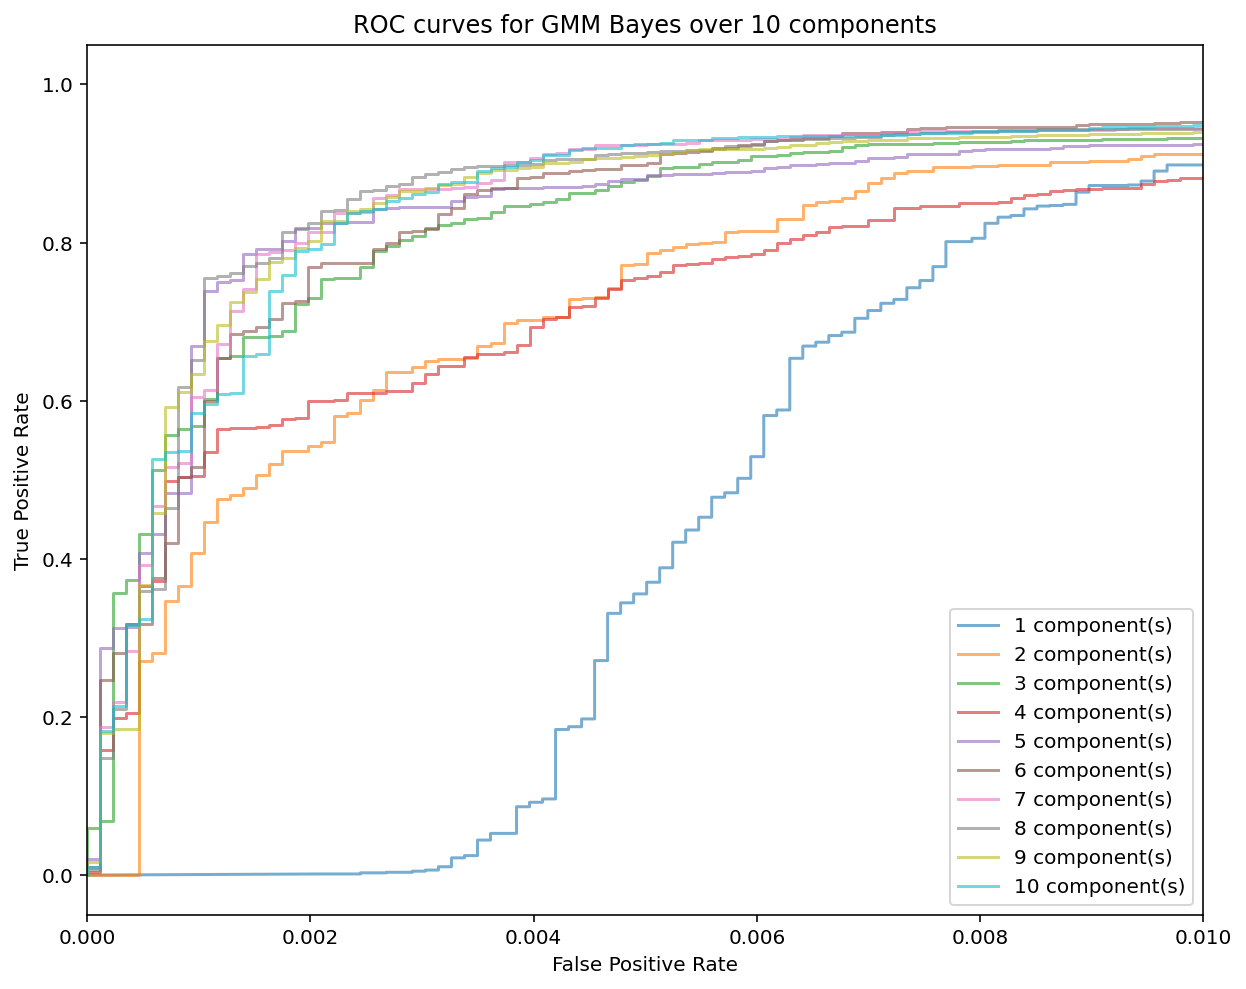

Best model uses 9 components


In [8]:
# BS - import the GMM Bayes package
from astroML.classification import GMMBayes

# BS - stack the data restricted to just the color data
X_color = np.stack((u_g, g_r, r_i, i_z), axis=1)

# BS - split the new 'just color' data into training and testing
X_ctrain, X_ctest, y_ctrain, y_ctest = train_test_split(X_color, y, test_size=0.2, random_state=0)

# BS - create an array of components to loop over (1 - 10)
components = np.arange(1, 11)

# BS arrays for fprs, tprs, and areas under curve for GMMB
fprs_gmmb = []
tprs_gmmb = []
areas_gmmb = []

# BS - create the figure object
plt.figure(figsize=(10, 8))

# BS - loop over each component number, create the classifier object
# fit the classifier to the training data, calculate the probabilities
# on the testing data, calculate the false positive and true positive
# rates, calculate the area, and plot
for i in components:
    
    # BS - create the classifer objects looping through number of components
    clf = GMMBayes(n_components=i)
    
    # BS - fit the training data with the color restricted X and y
    clf.fit(X_ctrain, y_ctrain)

    # BS - calculate the probabilities
    y_probs = clf.predict_proba(X_ctest)[:, 1]
    
    # BS - calculate the false positive and true positive rates
    fpr, tpr, thresh = roc_curve(y_ctest, y_probs)
    fprs_gmmb.append(fpr)
    tprs_gmmb.append(tpr)
    
    # BS - calculate the areas
    mask = (fpr <= 0.01)
    area = np.trapz(tpr[mask], fpr[mask], axis=0)
    areas_gmmb.append(area)

    # BS - plot false positive vs. true positive for the iteration/number of components 
    plt.plot(fpr, tpr, alpha=0.6, label="%i component(s)" %i)


# BS - finish the plot
plt.xlim(0,0.01)  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for GMM Bayes over %i components" %np.max(components))
plt.legend()
plt.show()

# BS - print the best selection for number of components
best_gmmb_idx = np.argmax(areas_gmmb)
print("Best model uses {} components".format(best_gmmb_idx + 1))

# BS - append best GMMB to the overal best fprs and tprs arrays
best_fprs.append(fprs_gmmb[best_gmmb_idx])
best_tprs.append(tprs_gmmb[best_gmmb_idx])


#### Part 7

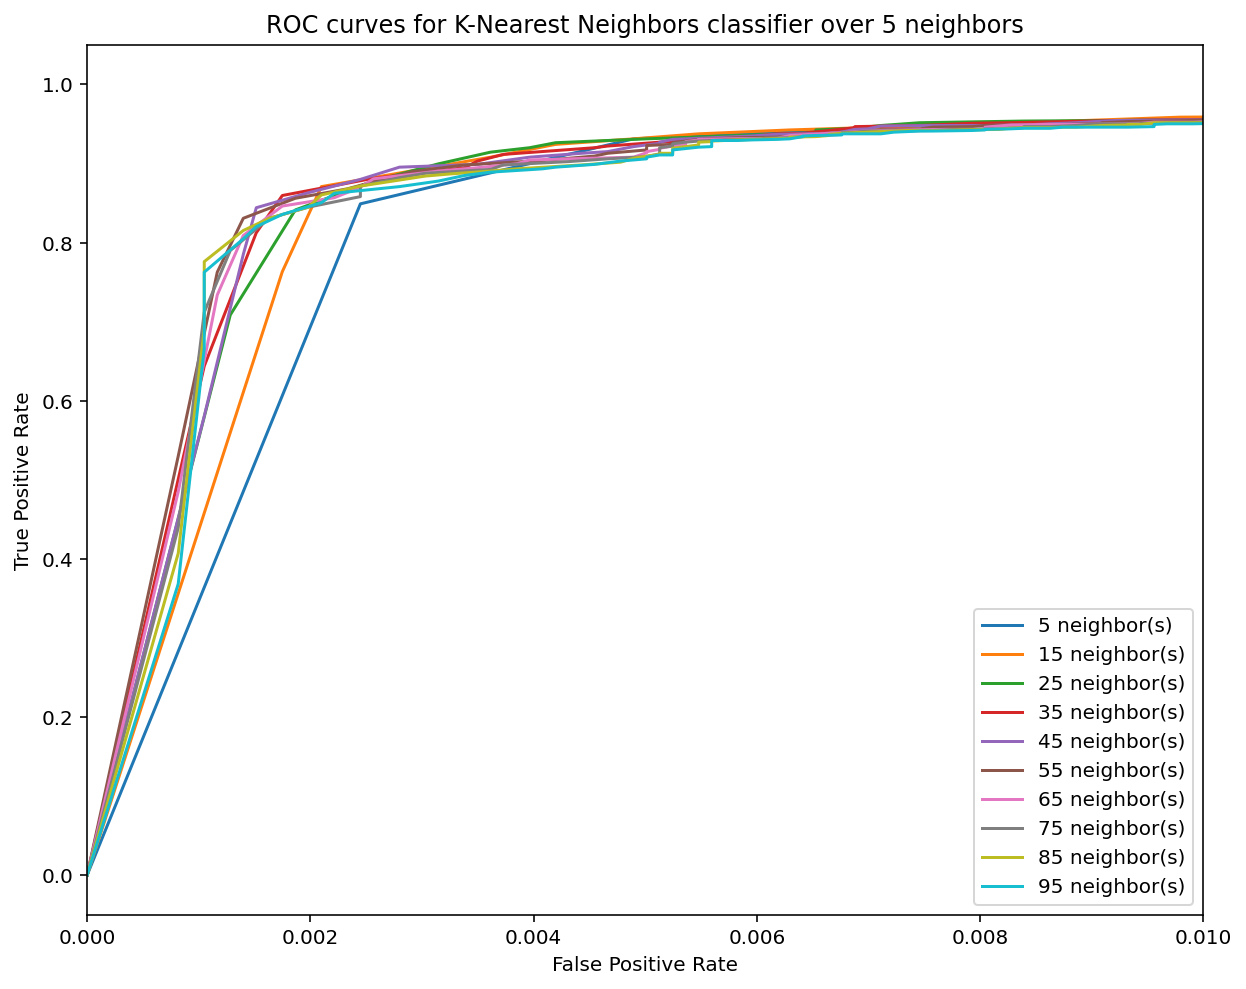

Best model uses 55 neighbors


In [9]:
# BS - import the K-Neighbors Classifier package
from sklearn.neighbors import KNeighborsClassifier

# BS - create the array for number of neighbors to iterate through
neighbors = np.arange(5, 100, 10)

# BS arrays for fprs, tprs, and areas under curve for KNN classifier
fprs_knn = []
tprs_knn = []
areas_knn = []
# BS - create the figure object
plt.figure(figsize=(10, 8))

# BS - loop over each neighbor number, create the classifier object
# fit the classifier to the training data, calculate the probabilities
# on the testing data, calculate the false positive and true positive
# rates, calculate the area, and plot
for i in neighbors:

    # BS - create the classifer objects looping through number of neighbors
    clf = KNeighborsClassifier(n_neighbors=i)
    
    # BS - fit the training data with the color restricted X and y
    clf.fit(X_ctrain, y_ctrain)

    # BS - calculate the probabilities
    y_probs = clf.predict_proba(X_ctest)[:, 1]
    
    # BS - calculate the false positive and true positive rates
    fpr, tpr, thresh = roc_curve(y_ctest, y_probs)
    fprs_knn.append(fpr)
    tprs_knn.append(tpr)
    
    # BS - calculate the areas
    mask = (fpr <= 0.01)
    area = np.trapz(tpr[mask], fpr[mask], axis=0)
    areas_knn.append(area)

    # BS - plot false positive vs. true positive for the iteration/number of neighbors 
    plt.plot(fpr, tpr, label="%i neighbor(s)" %i)
    
# BS - finish the plot
plt.xlim(0,0.01)  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for K-Nearest Neighbors classifier over %i neighbors" %len(X[0]))
plt.legend()
plt.show()
    
# BS - print the best selection for number of neighbors
best_knn_idx = np.argmax(areas_knn)
best_knn_neighbors = neighbors[best_knn_idx]
print("Best model uses {} neighbors".format(best_knn_neighbors))

# BS - append best KNN to the overal best fprs and tprs arrays
best_fprs.append(fprs_knn[best_knn_idx])
best_tprs.append(tprs_knn[best_knn_idx])


#### Part 8

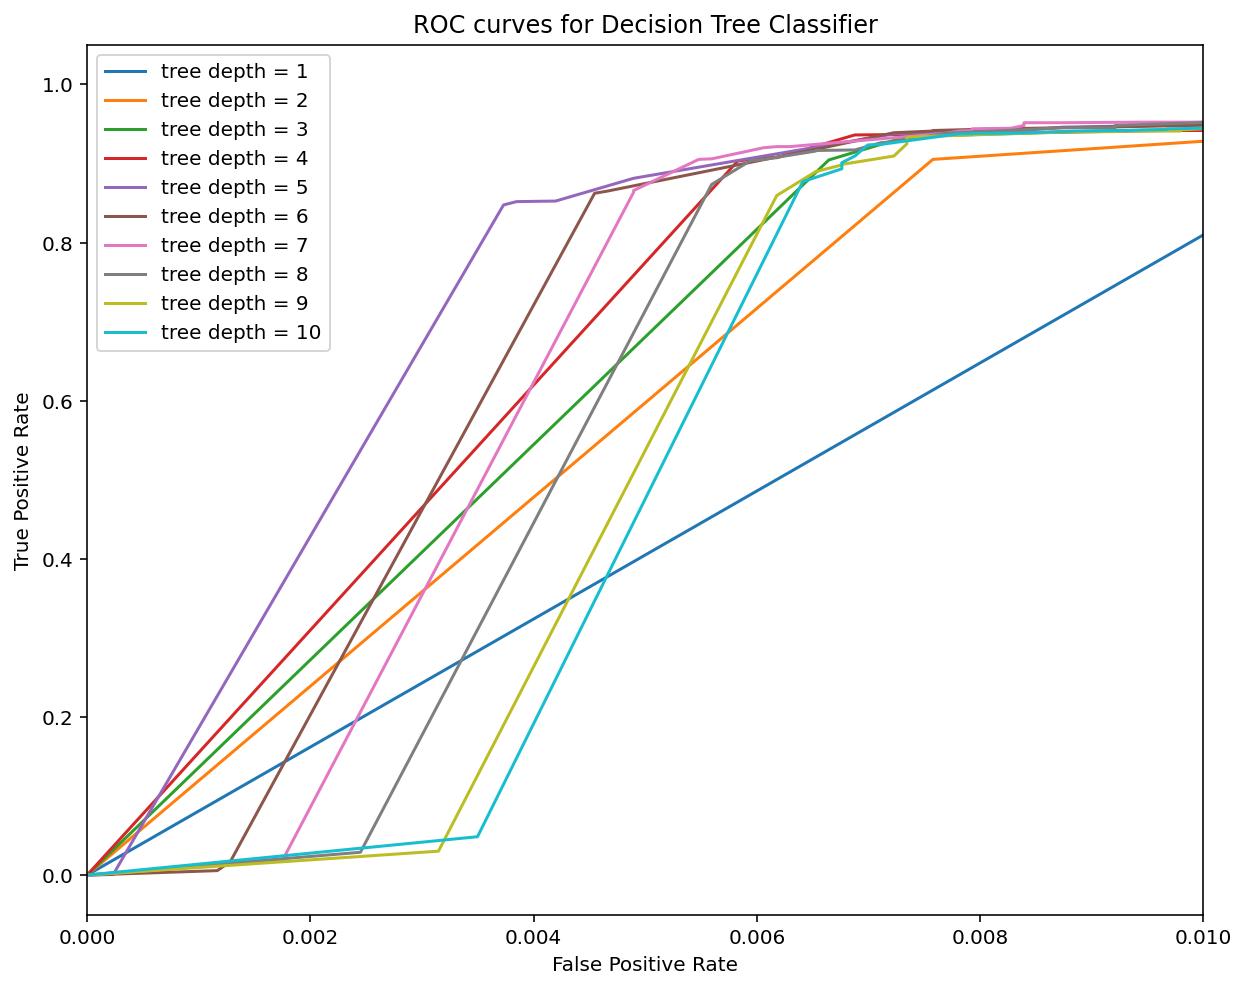

Best model has max tree depth of 5


In [10]:
# BS - import the Decision Tree Classifier package
from sklearn.tree import DecisionTreeClassifier

# BS - reassign components since it is the same range
depth = components

# BS arrays for fprs, tprs, and areas under curve for DT classifier
fprs_dt = []
tprs_dt = []
areas_dt = []

# BS - create the figure object
plt.figure(figsize=(10, 8))


# BS - loop over each tree depth number, create the classifier object
# fit the classifier to the training data, calculate the probabilities
# on the testing data, calculate the false positive and true positive
# rates, calculate the area, and plot
for i in depth:

    # BS - create the classifer objects looping through tree depth
    clf = DecisionTreeClassifier(random_state = 0, max_depth=i)
    
    # BS - fit the training data with the color restricted X and y
    clf.fit(X_ctrain, y_ctrain)

    # BS - calculate the probabilities
    y_probs = clf.predict_proba(X_ctest)[:, 1]
    
    # BS - calculate the false positive and true positive rates
    fpr, tpr, thresh = roc_curve(y_test, y_probs)
    fprs_dt.append(fpr)
    tprs_dt.append(tpr)
    
    # BS - calculate the areas
    mask = (fpr <= 0.01)
    area = np.trapz(tpr[mask], fpr[mask], axis=0)
    areas_dt.append(area)
    
    # BS - plot false positive vs. true positive for the iteration/number of neighbors
    plt.plot(fpr, tpr, label="tree depth = %i" %i)
    
# BS - finish the plot
plt.xlim(0,0.01)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for Decision Tree Classifier")
plt.legend()
plt.show()

# BS - print the best selection for tree depth
best_dt_idx = np.argmax(areas_dt)
best_tree_depth = depth[best_dt_idx]
print("Best model has max tree depth of {}".format(best_tree_depth + 1))

# BS - append best DT to the overal best fprs and tprs arrays
best_fprs.append(fprs_dt[best_dt_idx])
best_tprs.append(tprs_dt[best_dt_idx])

#### Part 9

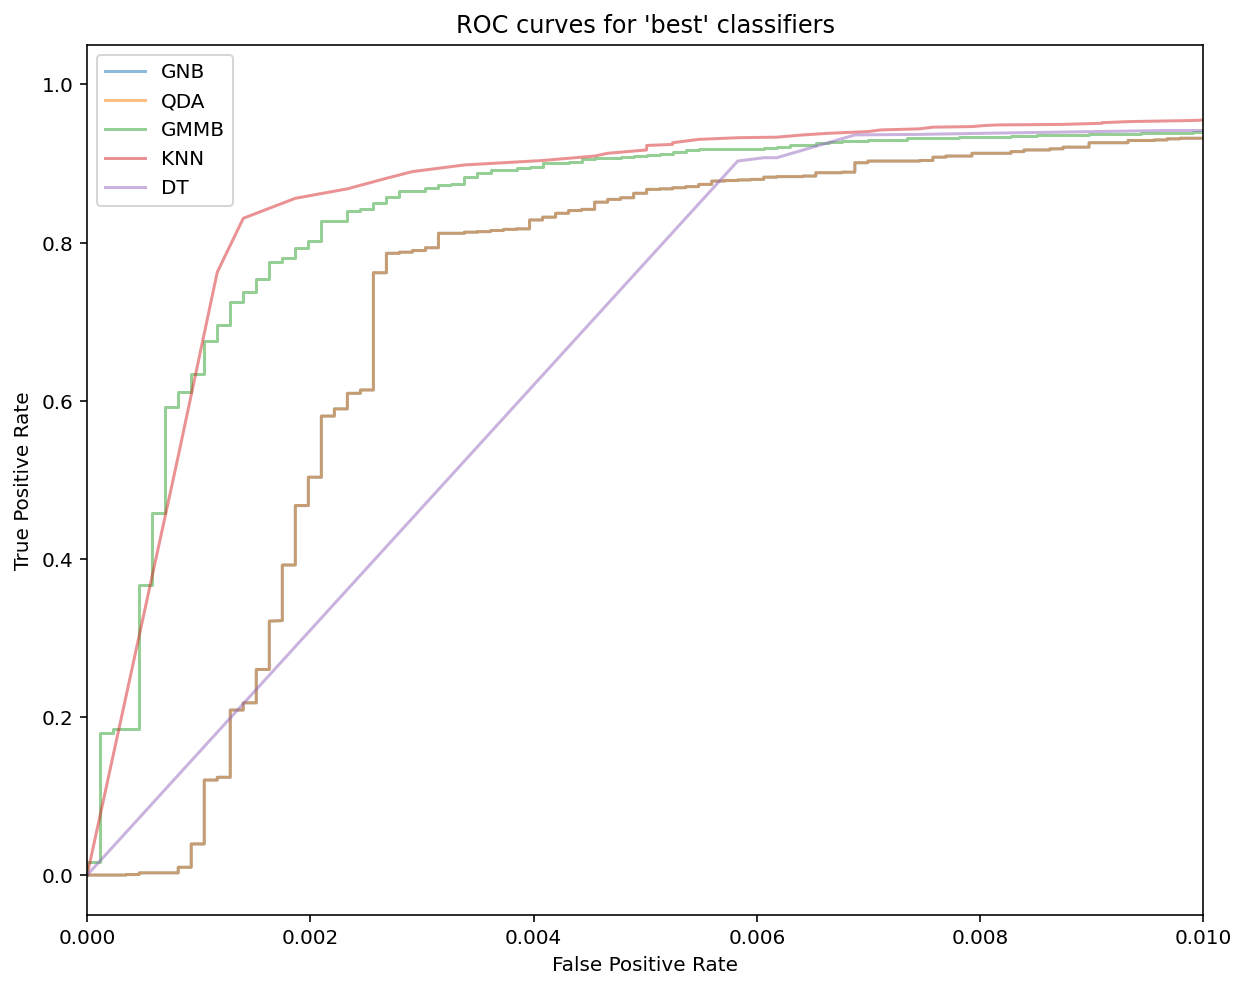

Best Model is: KNN


In [11]:
# BS - TIME TO COMPARE THE BEST OF EACH CLASSIFIER!

# BS - create array of model names for plotting later
models = (['GNB','QDA','GMMB','KNN', 'DT' ])

# BS - since I didn't have the foresight to save the areas earlier, 
# I am being lazy and recalculating the areas again since it is easier
# to recycle the code from above to do it again instead of doing 
# "code surgery" to pull them out (sorry...)
best_areas = []

# BS - create the figure object
plt.figure(figsize=(10, 8))

for i in range(len(best_fprs)):
    
    # BS - reassign (just to make life a little easier a few lines below)
    fprs = best_fprs[i]
    tprs = best_tprs[i]
    
    # BS - calculate the areas of each "best" (again)
    mask = (fprs <= 0.01)
    area = np.trapz(tprs[mask], fprs[mask], axis=0)
    best_areas.append(area)

    # BS - plot each "best" ROC
    plt.plot(fprs, tprs, alpha=0.5, label=models[i])

# BS - finish the plot
plt.xlim(0,0.01)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for 'best' classifiers")
plt.legend()
plt.show()

# BS - find and print the best of the best
best_model = np.argmax(best_areas)
print("Best Model is: {}".format(models[best_model]))
    

SRT: Excellent work!

#### Part 10

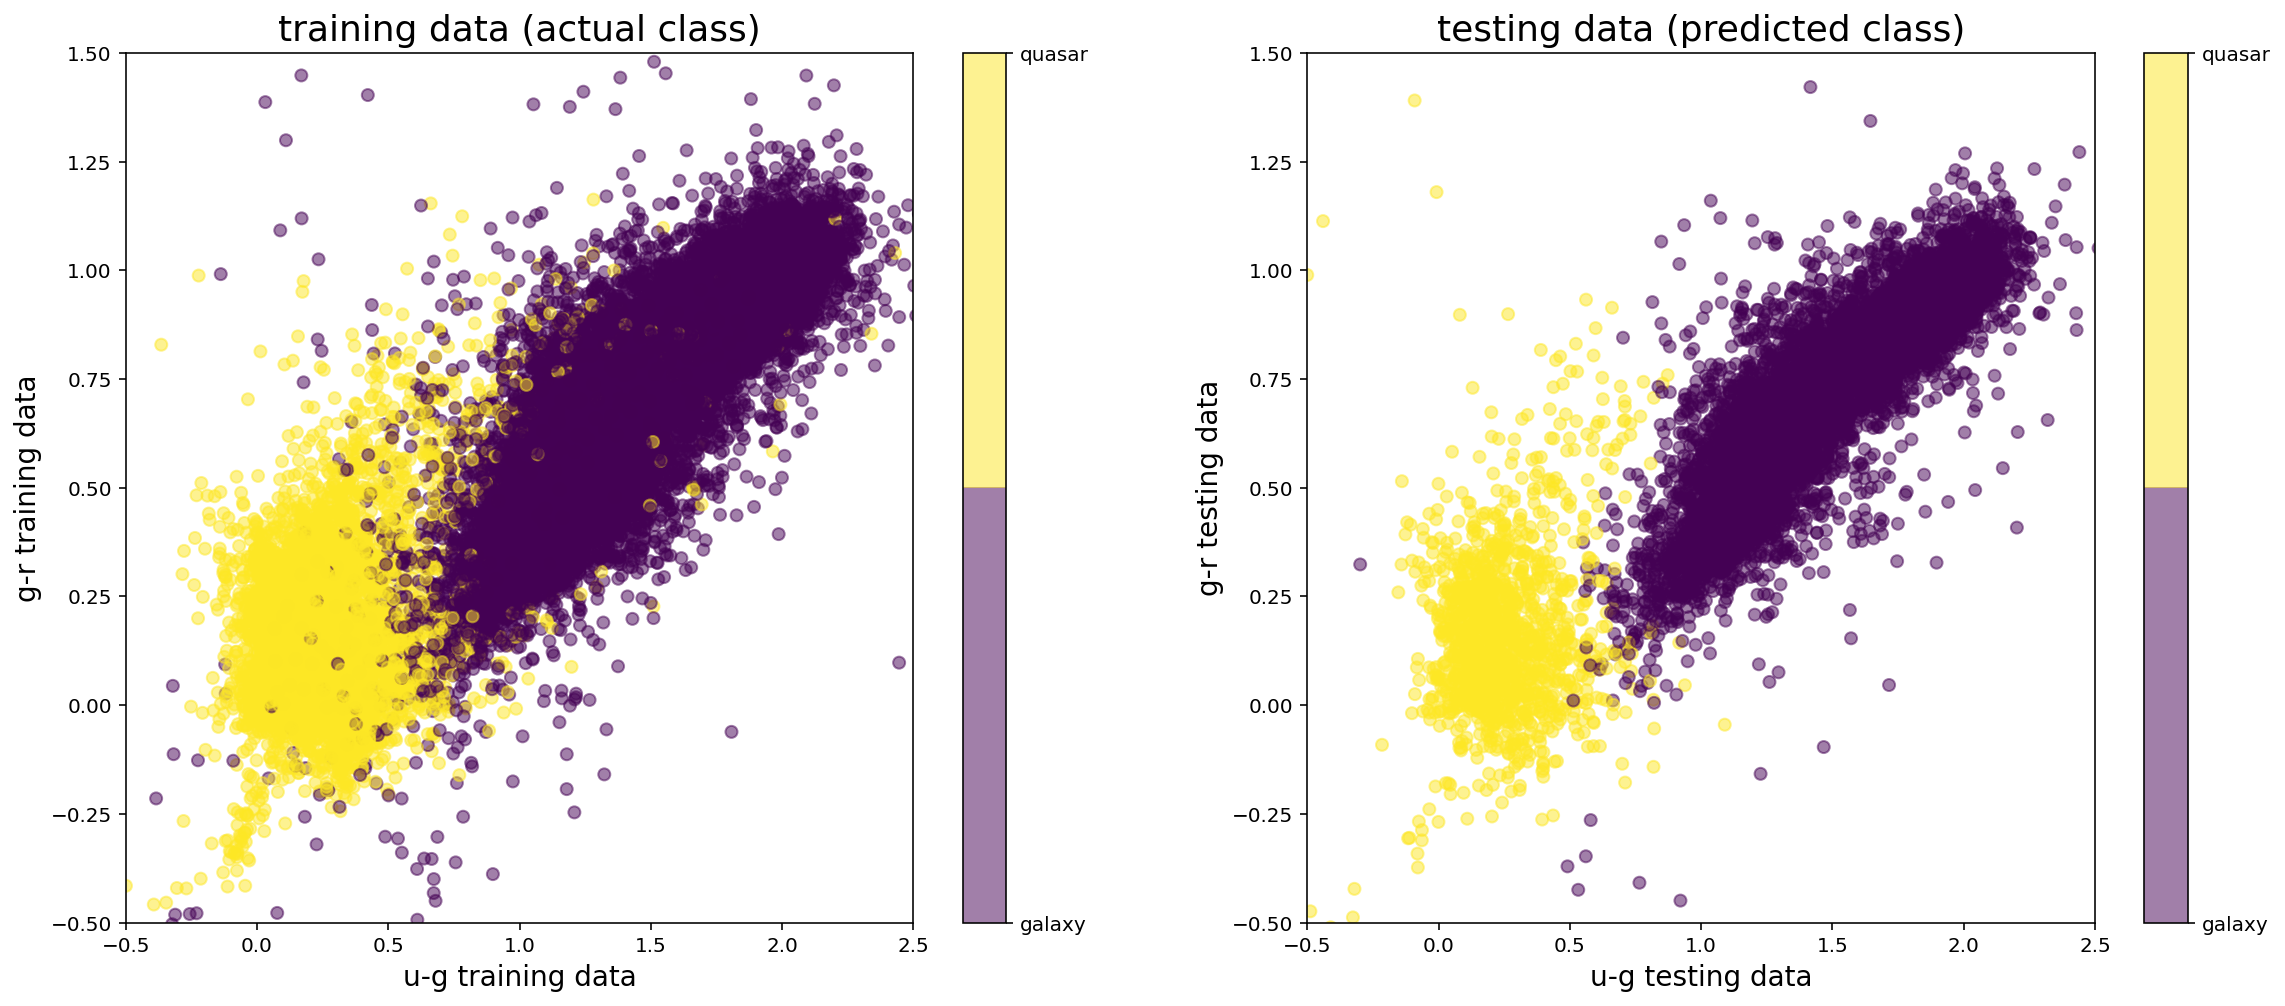

In [12]:
# BS - the final plot

# BS - create the necessary prediction for the test data from
# the training data
clf = KNeighborsClassifier(n_neighbors=best_knn_neighbors)
clf.fit(X_ctrain, y_ctrain)
y_predict = clf.predict(X_ctest)


fig = plt.figure(figsize=(30,8))

# BS - figure for the training data (left)
ax1 = plt.subplot(131)
ax1.set_xlim(-0.5, 2.5)
ax1.set_ylim(-0.5, 1.5)
im1 = ax1.scatter(X_ctrain[:,0], X_ctrain[:,1], c=y_ctrain, cmap=plt.cm.get_cmap('viridis', 2), alpha=0.5)
ax1.set_xlabel("u-g training data", fontsize=14)
ax1.set_ylabel("g-r training data", fontsize=14)
ax1.set_title("training data (actual class)", fontsize=18)
cbar1 = fig.colorbar(im1, ax=ax1, ticks=[0, 1])
cbar1.ax.set_yticklabels(['galaxy', 'quasar'])

# BS - figure for the testing data (right)
ax2 = plt.subplot(132)
ax2.set_xlim(-0.5, 2.5)
ax2.set_ylim(-0.5, 1.5)
im2 = ax2.scatter(X_ctest[:,0], X_ctest[:,1], c=y_predict, cmap=plt.cm.get_cmap('viridis', 2), alpha=0.5)
ax2.set_xlabel("u-g testing data", fontsize=14)
ax2.set_ylabel("g-r testing data", fontsize=14)
ax2.set_title("testing data (predicted class)", fontsize=18)
cbar2 = fig.colorbar(im2, ax=ax2, ticks=[0, 1])
cbar2.ax.set_yticklabels(['galaxy', 'quasar'])
plt.show()

Final note: Now that I am at the end and looking over my work, I would redo a lot of this code. I completely acknowledge how much I recycled code and probably could have 'functionalized' and streamlined a lot of things. I would actually love to go back and practice doing just that if I could find the time...

SRT: I am glad that this has inspired you to streamline your coding practices. It's always a balance between what could be better, and what is good enough. In this case, writing a skeleton function to slot all these different classifiers into would be optimal, but if it takes longer to code than doing the homework like these, then it's maybe not efficient. However, in research it almost always pays dividends to write your code as efficiently as possible.